In [3]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
#from tensorflow.keras.utils import plot_model


# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json

In [66]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    wind_speeds = []

    for path in paths:
        wind_speeds = np.append(wind_speeds, int(path['maxwind']))

    highest_wind = max(wind_speeds)
    
    return highest_wind

def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    imerg_array = np.load(precips[0])
    
    for file in precips[1:5]:
        imerg_array = np.append(imerg_array, np.load(file), axis = 0)
    imerg_array = imerg_array.reshape(1, 5, 100, 100)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 100, 100)
    
    return sst_array

In [68]:
highest_wind = np.empty([0])
imerg_precip = np.empty([1, 5, 100, 100])
skin_temp = np.empty([1, 4, 100, 100])

folders = glob.glob('/home/fun/data/AL*2012')
for folder in folders:
    imerg_names = folder + '/imerg_precipitation_*.npy'
    sst_names = folder + '/noaa_sst_*.npy'
    imerg_precip = np.append(imerg_precip, get_imerg(imerg_names), axis = 0) # X data (train class)
    skin_temp = np.append(skin_temp, get_sst(sst_names), axis = 0) # X data (train class)
    highest_wind = np.append(highest_wind, get_max_wind(folder)) # Y data (target class)

imerg_precip = imerg_precip[1:]
skin_temp = skin_temp[1:]
    
print(imerg_precip.shape, skin_temp.shape, highest_wind.shape) # 19 hurricanes, 5 days, 100x100 images

(19, 5, 100, 100) (19, 4, 100, 100) (19,)


In [69]:
final = np.append(imerg_precip, skin_temp, axis = 1)
final.shape

(19, 9, 100, 100)

In [70]:
for i in range(final.shape[0]):
    for j in range(final.shape[1]):
        scaler = StandardScaler()
        scaler.fit(final[i, j, :, :])
        final[i, j, :, :] = scaler.transform(final[i, j, :, :])
        
final

array([[[[-0.17308819, -0.23488755, -0.30136114, ..., -0.18499407,
          -0.10050378,  0.        ],
         [-0.17308819, -0.23488755, -0.30136114, ...,  1.30634588,
          -0.10050378,  0.        ],
         [-0.17308819, -0.22493174, -0.30136114, ...,  8.42544353,
          -0.10050378,  0.        ],
         ...,
         [-0.17308819, -0.23488755, -0.30136114, ..., -0.18499407,
          -0.10050378,  0.        ],
         [-0.17308819, -0.23488755, -0.30136114, ..., -0.18499407,
          -0.10050378,  0.        ],
         [-0.17308819, -0.23488755, -0.30136114, ..., -0.18499407,
          -0.10050378,  0.        ]],

        [[-0.18507911, -0.12863319, -0.13181743, ..., -0.27892732,
          -0.29339435, -0.3002281 ],
         [-0.18507911, -0.12863319, -0.13181743, ..., -0.27892732,
          -0.29339435, -0.3002281 ],
         [-0.18507911, -0.12863319, -0.13181743, ..., -0.27892732,
          -0.29339435, -0.3002281 ],
         ...,
         [-0.18507911, -0.12863319

In [71]:
final = final.astype("float32")
highest_wind = highest_wind.astype("float32")

final = np.swapaxes(final, 1, 2)
final = np.swapaxes(final, 2, 3)
final.shape

(19, 100, 100, 9)

In [88]:
# img
X_train, X_test, y_train, y_test = train_test_split(
    final, highest_wind, train_size = 0.7, random_state = 782378)


print(X_train.shape, y_train.shape)


(13, 100, 100, 9) (13,)


In [89]:
# feature extraction from spatial data
spatial_inputs = Input(shape = (100, 100, 9),
                      name = 'Spatial_Input')

spatial_conv1 = Conv2D(filters = 5, 
               kernel_size = (7, 7), 
               activation = 'relu', 
               padding = "same", 
               name = 'Spatial_Conv_1')(spatial_inputs)

spatial_pool1 = AveragePooling2D(pool_size = (2,2), 
                         strides = 2,
                         name = 'Spatial_Avg_Pool_1')(spatial_conv1)

spatial_batch1 = BatchNormalization(name = 'Spatial_Batch_Norm_1')(spatial_pool1)

spatial_flat = Flatten(name = 'Spatial_Flatten')(spatial_batch1)

dense1 = Dense(32, activation = 'relu', name = 'Fully_Connected_1')(spatial_flat)
dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

output = Dense(1, activation = 'relu', name = 'Output_Layer')(dense1dropout)

# create model with two inputs
model = Model([spatial_inputs], output)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Spatial_Input (InputLayer)   [(None, 100, 100, 9)]     0         
_________________________________________________________________
Spatial_Conv_1 (Conv2D)      (None, 100, 100, 5)       2210      
_________________________________________________________________
Spatial_Avg_Pool_1 (AverageP (None, 50, 50, 5)         0         
_________________________________________________________________
Spatial_Batch_Norm_1 (BatchN (None, 50, 50, 5)         20        
_________________________________________________________________
Spatial_Flatten (Flatten)    (None, 12500)             0         
_________________________________________________________________
Fully_Connected_1 (Dense)    (None, 32)                400032    
_________________________________________________________________
Dense_Dropout_1 (Dropout)    (None, 32)                0   

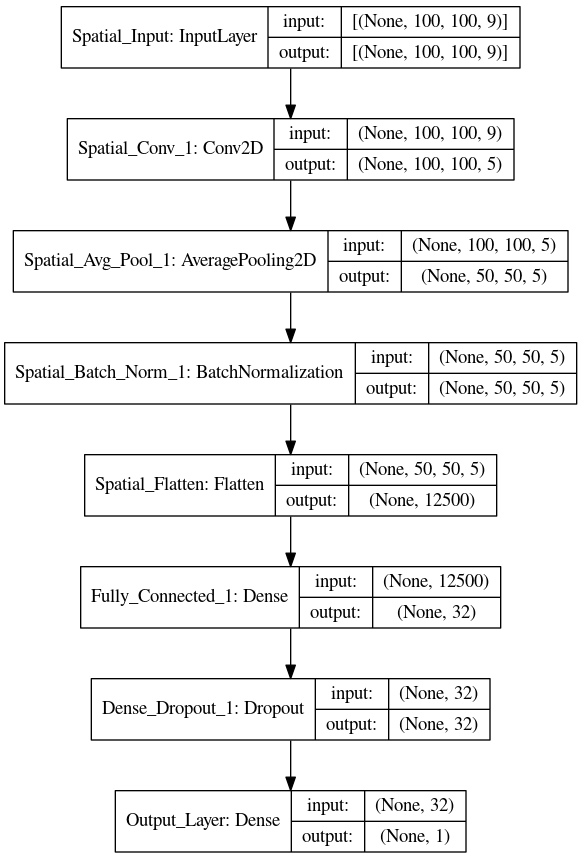

In [76]:
tf.keras.utils.plot_model(model, to_file='dense_plot.png', show_shapes=True, show_layer_names=True)

In [90]:
model.compile(
    loss = keras.losses.MeanSquaredError(), 
    optimizer = "adam",
    metrics = ['acc']
)

In [91]:
history = model.fit([X_train], y_train, 
          batch_size = 5, 
          epochs = 20, 
          validation_data = ([X_test], y_test), 
          )



Epoch 1/20
3/3 [==============================] - 1s 101ms/step - loss: 4871.0449 - acc: 0.0000e+00 - val_loss: 4600.0000 - val_acc: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 0s 57ms/step - loss: 3659.5923 - acc: 0.0000e+00 - val_loss: 4285.7847 - val_acc: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 0s 57ms/step - loss: 2733.8354 - acc: 0.0000e+00 - val_loss: 3183.6985 - val_acc: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 0s 57ms/step - loss: 2278.4050 - acc: 0.0000e+00 - val_loss: 2356.4641 - val_acc: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 0s 56ms/step - loss: 2116.4302 - acc: 0.0000e+00 - val_loss: 2390.9778 - val_acc: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 0s 57ms/step - loss: 2403.9260 - acc: 0.0000e+00 - val_loss: 2642.2166 - val_acc: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 0s 55ms/step - loss: 1663.0391 - acc: 0.0000e+00 - val_loss: 3051.0237 - val_acc: 0.0000e+0

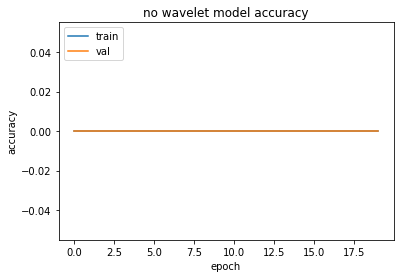

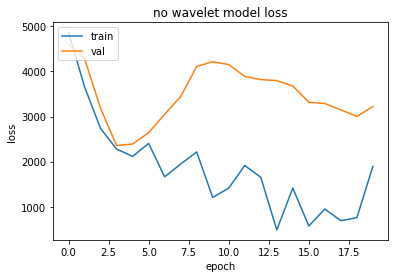

In [92]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('no wavelet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('no wavelet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

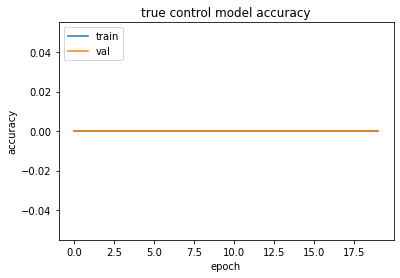

In [93]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('true control model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')
plt.show()

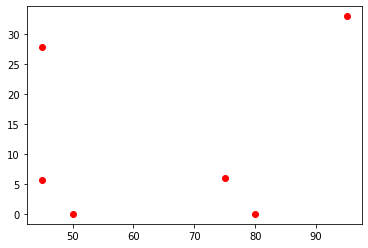

In [95]:
plt.plot(y_test, y_pred, 'ro')

In [94]:
y_pred = model.predict([X_test])
y_pred_round = np.rint(y_pred)

y_pred_round = y_pred_round.reshape(y_pred_round.shape[0])

print(y_pred_round)

[33.  6.  0.  6.  0. 28.]


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("precision: ", precision_score(y_test_spatial, y_pred_round))
print("recall: ", recall_score(y_test_spatial, y_pred_round))
print("f1 score: ", f1_score(y_test_spatial, y_pred_round))

NameError: name 'y_test_spatial' is not defined

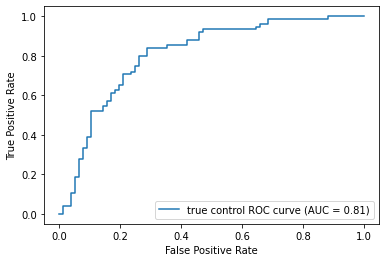

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_spatial, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='true control ROC curve')
display.plot()

plt.show()

In [34]:
def draw_confusion_matrix(y, yhat, classes):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("true control confusion matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

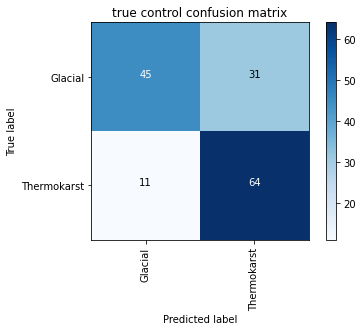

In [35]:
draw_confusion_matrix(y_test_spatial, y_pred_round, ['Glacial', 'Thermokarst'])
fig = plt.ylabel('True label')
fig = plt.xlabel('Predicted label')
fig = plt.show()